In [ ]:
!git clone https://github.com/MagicShow1999/CV-Final-Project
%cd CV-Final-Project/

Cloning into 'CV-Final-Project'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 59 (delta 5), reused 9 (delta 2), pack-reused 44
Unpacking objects: 100% (59/59), done.
/content/CV-Final-Project


In [ ]:
import torch 
from torchvision import transforms, models, datasets 
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import util
import time
import tqdm
import os

device = ("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
%matplotlib inline

# 1. Set up

## 1.1 Hyperparmeter


In [ ]:
# Hyperparmeter
TRAIN_IMAGE_SIZE = 224
EPOCHS = 1
BATCH_SIZE = 4 
CONTENT_WEIGHT = 1
STYLE_WEIGHTS = {
          "relu1_2":1e3,
          "relu2_2":1e4,
          "relu3_3":1e4,
          "relu4_3":5e3
      }
#STYLE_WEIGHTS = {
#          "relu1_2":1e3,
#          "relu2_2":1e4,
#          "relu3_3":1e4,
#          "relu4_3":5e3
#      }
LOG_INTERVAL = 2000
LR = 0.001
REGULARIZATION = 1e-6

In [ ]:
# read image
style = util.read_image('./image/mosaic.jpeg', TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE).to(device)
content = util.read_image('./image/content_img_2.jpg', TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE).to(device)

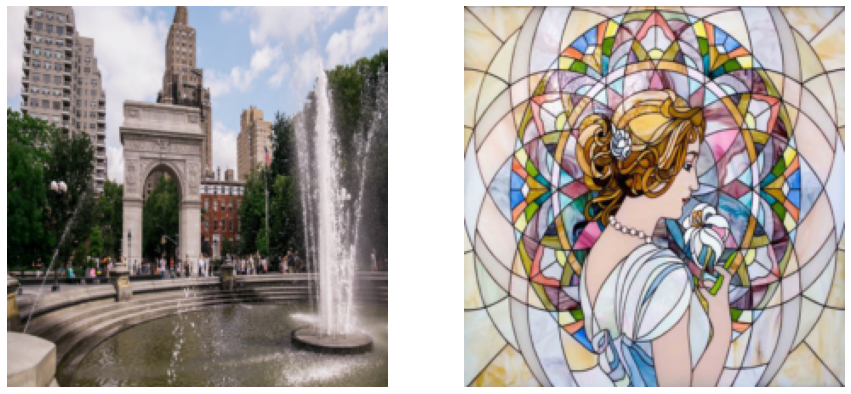

In [ ]:
# show image
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(util.torchTensorToImage(content),label = "Content")
ax1.axis("off")
ax2.imshow(util.torchTensorToImage(style),label = "Style")
ax2.axis("off")
plt.show()

## 1.2 Loss Network

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class LossNet(nn.Module):
  """
  The loss network is used to define a feature reconstruction loss and a style reconstruction loss 
  that measure differences in content and style between images
  """
  def __init__(self):
      super(LossNet, self).__init__()
      self.vgg = models.vgg16(pretrained=True).features
      self.layers = {
          '3': "relu1_2",
          '8': "relu2_2",
          '15': "relu3_3",
          '22': "relu4_3",
      }
      for p in self.vgg.parameters():
          p.requires_grad = False

  def forward(self, x):
    features = {}
    for name,layer in self.vgg._modules.items():
      x = layer(x)
      if name in self.layers:
        features[self.layers[name]] = x 
    return features

## 1.3 Transform Network

 #### 1.3.1 Convolution Layer

In [ ]:
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        padding_size = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(padding_size)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        return self.conv2d(self.reflection_pad(x))

 #### 1.3.2 Residual Block

In [ ]:
class ResidualBlock(torch.nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.ConvLayers = nn.Sequential(
            ConvLayer(channels, channels, 3, 1),
            torch.nn.InstanceNorm2d(channels, affine=True),
            torch.nn.ReLU(),
            ConvLayer(channels, channels, 3, 1),
            torch.nn.InstanceNorm2d(channels, affine=True) 
        ) # ReLU nonlinearity following the addition is removed;

    def forward(self, x):
        identity = x
        x = self.ConvLayers(x)
        return x + identity

 #### 1.3.3 DeConvolution Layer

In [ ]:
class DeConvLayer(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding):
        super(DeConvLayer, self).__init__()
        padding_size = kernel_size // 2
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding_size, output_padding)
        
    def forward(self, x):
        return self.conv_transpose(x)

In [ ]:
class TransformNet(torch.nn.Module):
  """
  The image transformation network is trained to minimize a weighted combination of loss functions
  The exact architectures of this networks can be found in the supplementary material of the paper
  https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf
  """
  def __init__(self):
      super(TransformNet, self).__init__()
      # Convolution layers
      self.ConvLayers = nn.Sequential(
          ConvLayer(3, 32, 9, 1),
          torch.nn.InstanceNorm2d(32, affine=True),
          torch.nn.ReLU(),
          ConvLayer(32, 64, 3, 2),
          torch.nn.InstanceNorm2d(64, affine=True),
          torch.nn.ReLU(),
          ConvLayer(64, 128, 3, 2),
          torch.nn.InstanceNorm2d(128, affine=True),
          torch.nn.ReLU()
      )

      # Residual blocks
      self.ResidualBlocks = nn.Sequential(
          ResidualBlock(128),
          ResidualBlock(128),
          ResidualBlock(128),
          ResidualBlock(128),
          ResidualBlock(128)
      )

      # Deconvolutional layers
      self.DeConvLayers = nn.Sequential(
          DeConvLayer(128, 64, 3, 2, 1),
          torch.nn.InstanceNorm2d(64, affine=True),
          torch.nn.ReLU(),
          DeConvLayer(64, 32, 3, 2, 1),
          torch.nn.InstanceNorm2d(32, affine=True),
          torch.nn.ReLU(),
          ConvLayer(32, 3, 9, 1),
      )

  def forward(self, x):
      x = self.ConvLayers(x)
      x = self.ResidualBlocks(x)
      x = self.DeConvLayers(x)
      return x

# Train

### 2.1 Prepare Training set (COCO)

In [ ]:
# Download dataset (COCO2014)
# https://cocodataset.org/#download
# TODO change val to train
!wget http://images.cocodataset.org/zips/train2014.zip 

--2021-12-16 01:03:30--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.36.220
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.36.220|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  45.6MB/s    in 4m 26s  

2021-12-16 01:07:57 (48.4 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [ ]:
!mkdir dataset
!mkdir model_checkpoints
!mkdir transformed_images

In [ ]:
!unzip -qq train2014.zip -d /content/CV-Final-Project/dataset/train2014
!rm train2014.zip 

In [ ]:
# Get Training Dataset 
transform = util.common_transforms(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE)
# ref: https://pytorch.org/vision/0.8/datasets.html#imagefolder
train_dataset = datasets.ImageFolder("/content/CV-Final-Project/dataset/", transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

### 2.2 Init Model & Optimizer

In [ ]:
# Model
transform_net = TransformNet().to(device)
transform_net.train()

with torch.no_grad():
    vgg = LossNet()
    vgg.to(device)
vgg.eval()

# Optimizer
optimizer = torch.optim.Adam(transform_net.parameters(),lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

### 2.3 Prepare Style Features

In [ ]:
# Style Features
B, C, H, W = style.shape
style_features = vgg(style.expand([BATCH_SIZE, C, H, W]))
style_grams = {}
for layer, feature in style_features.items():
    style_grams[layer] = util.gram_matrix(feature)

### 2.4 Training

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



Train Epoch: 1 [0/82783 (0%)]
	Content Loss: 7.976461	Style Loss: 18.548906	Total Loss: 26.939726
Time elapsed:	0.344815731048584 seconds
Successfully save the final stylized image to: ./transformed_images/img_1_0.png

Train Epoch: 1 [8000/82783 (10%)]
	Content Loss: 7.010653	Style Loss: 4.806638	Total Loss: 12.160378
Time elapsed:	250.4592990875244 seconds
Successfully save the final stylized image to: ./transformed_images/img_1_8000.png

Train Epoch: 1 [16000/82783 (19%)]
	Content Loss: 6.134027	Style Loss: 3.942906	Total Loss: 10.405070
Time elapsed:	499.1240005493164 seconds
Successfully save the final stylized image to: ./transformed_images/img_1_16000.png

Train Epoch: 1 [24000/82783 (29%)]
	Content Loss: 5.744607	Style Loss: 3.630872	Total Loss: 9.695936
Time elapsed:	747.3648509979248 seconds
Successfully save the final stylized image to: ./transformed_images/img_1_24000.png

Train Epoch: 1 [32000/82783 (39%)]
	Content Loss: 5.527007	Style Loss: 3.469653	Total Loss: 9.312516
T

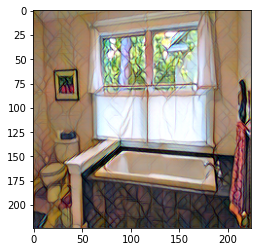

In [ ]:
content_loss_history = []
style_loss_history = []
total_loss_history = []
begin_time = time.time()
batch_count = 0
for epoch in range(1, EPOCHS + 1):
  content_loss_sum = 0
  style_loss_sum = 0
  total_loss_sum = 0
  for batch_idx, (data, _) in enumerate(train_loader):
    curr_batch_size = data.shape[0]
    batch_count += 1
    # if device == "cuda":
    #  torch.cuda.empty_cache() # Free-up memory
    optimizer.zero_grad()
    scheduler.step()
    
    # Get transformed images and features generated by transformed images
    content_imgs = data.to(device)
    transformed_imgs = transform_net(content_imgs)
    content_features = vgg(content_imgs)
    transformed_features = vgg(transformed_imgs)

    # Content Loss
    MSELoss = nn.MSELoss().to(device)
    content_loss = CONTENT_WEIGHT * MSELoss(transformed_features['relu2_2'], content_features['relu2_2'])   
    content_loss_sum += content_loss.item()
    
    # Style Loss
    style_loss = 0
    for layer, feature in transformed_features.items():
      style_gram = style_grams[layer][:curr_batch_size]
      transformed_gram = util.gram_matrix(feature)
      style_loss += MSELoss(transformed_gram, style_gram) * STYLE_WEIGHTS[layer]
    style_loss_sum += style_loss.item()

    # Regularization Loss (TODO)
    regularization = REGULARIZATION * (
                torch.sum(torch.abs(transformed_imgs[:, :, :, :-1] - transformed_imgs[:, :, :, 1:])) + 
                torch.sum(torch.abs(transformed_imgs[:, :, :-1, :] - transformed_imgs[:, :, 1:, :])))

    # Total Loss
    total_loss = content_loss + style_loss + regularization
    total_loss_sum += total_loss.item()

    # Backprop and Weight Update
    total_loss.backward()
    optimizer.step()
    if batch_idx % LOG_INTERVAL == 0:
        print('\nTrain Epoch: {} [{}/{} ({:.0f}%)]'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader)))
        print('\tContent Loss: {:.6f}\tStyle Loss: {:.6f}\tTotal Loss: {:.6f}'.format(
            content_loss_sum/batch_count, style_loss_sum/batch_count, total_loss_sum/batch_count))
        print("Time elapsed:\t{} seconds".format(time.time()-begin_time))
        content_loss_history.append(content_loss_sum/batch_count)
        style_loss_history.append(style_loss_sum/batch_count)
        total_loss_history.append(total_loss_sum/batch_count)

        # Save model checkpoint
        # model_file = './model_checkpoints/checkpoint_{}_{}.pth'.format(epoch, batch_idx//LOG_INTERVAL)
        # torch.save(transform_net.state_dict(), model_file)
        # print('Saved model to ' + model_file + '.')

        # Save image
        transformed_img = transformed_imgs[0].clone().detach().unsqueeze(dim=0)
        image_path = './transformed_images/img_{}_{}.png'.format(epoch, batch_idx*4)
        util.save_image(transformed_img, image_path)
        sampe_image = util.read_image(image_path, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE).to(device)
        plt.imshow(util.torchTensorToImage(sampe_image),label = "Content")

  # Save final model weights
  final_path = "./model_checkpoints/transformation_network_weight.pth"
  torch.save(transform_net.state_dict(), final_path)
  print('Saved model to ' + final_path + '.')

In [ ]:
!zip -r /content/CV-Final-Project/imgs.zip /content/CV-Final-Project/transformed_images

  adding: content/CV-Final-Project/transformed_images/ (stored 0%)
  adding: content/CV-Final-Project/transformed_images/img_1_64000.png (deflated 0%)
  adding: content/CV-Final-Project/transformed_images/img_1_8000.png (deflated 0%)
  adding: content/CV-Final-Project/transformed_images/img_1_80000.png (deflated 0%)
  adding: content/CV-Final-Project/transformed_images/img_1_48000.png (deflated 0%)
  adding: content/CV-Final-Project/transformed_images/img_1_16000.png (deflated 0%)
  adding: content/CV-Final-Project/transformed_images/img_1_40000.png (deflated 0%)
  adding: content/CV-Final-Project/transformed_images/img_1_56000.png (deflated 0%)
  adding: content/CV-Final-Project/transformed_images/img_1_24000.png (deflated 0%)
  adding: content/CV-Final-Project/transformed_images/img_1_0.png (deflated 0%)
  adding: content/CV-Final-Project/transformed_images/img_1_72000.png (deflated 0%)
  adding: content/CV-Final-Project/transformed_images/img_1_32000.png (deflated 0%)


# Result

## 3.1 Sample some of the trained images


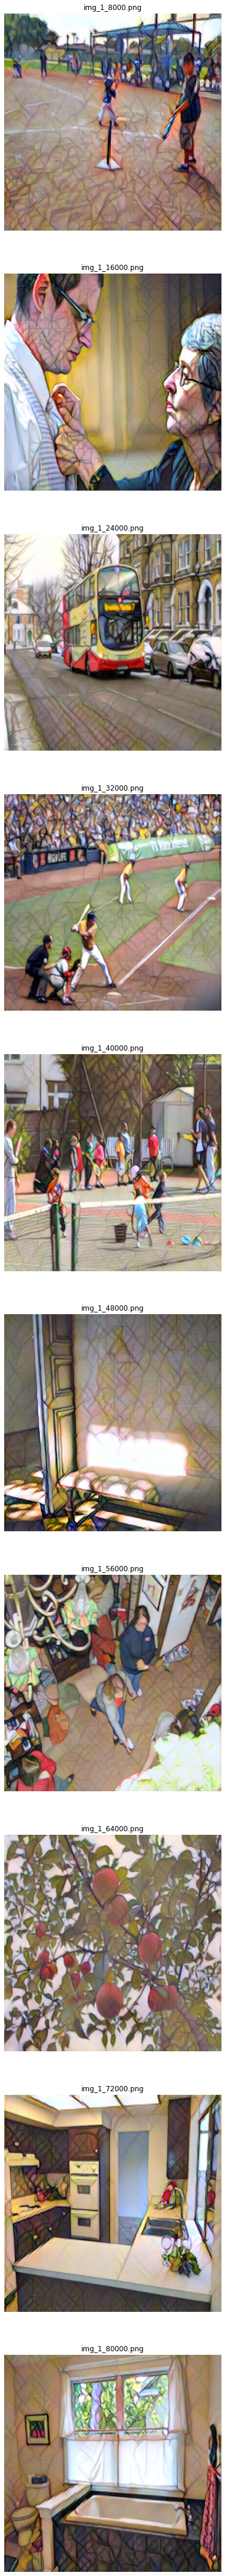

In [ ]:
cnt = len(train_dataset)//(BATCH_SIZE * LOG_INTERVAL)
_, ax = plt.subplots(cnt, 1,figsize = (8,cnt*8))
epoch = EPOCHS
for i in range(1, cnt+1):
  idx = LOG_INTERVAL * i * BATCH_SIZE
  image_name = 'img_{}_{}.png'.format(epoch, idx)
  image_path = './transformed_images/' + image_name
  sampe_image = util.read_image(image_path, TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE).to(device)
  ax[i-1].set_title(image_name)
  ax[i-1].imshow(util.torchTensorToImage(sampe_image))
  ax[i-1].axis("off")
plt.show()

## 3.2 Stylize unseen images

In [ ]:
transform_net.eval()
begin_time = time.time()
stylized_img = transform_net(content)
print("Time elapsed:\t{} seconds".format(time.time()-begin_time))

Time elapsed:	0.009690999984741211 seconds


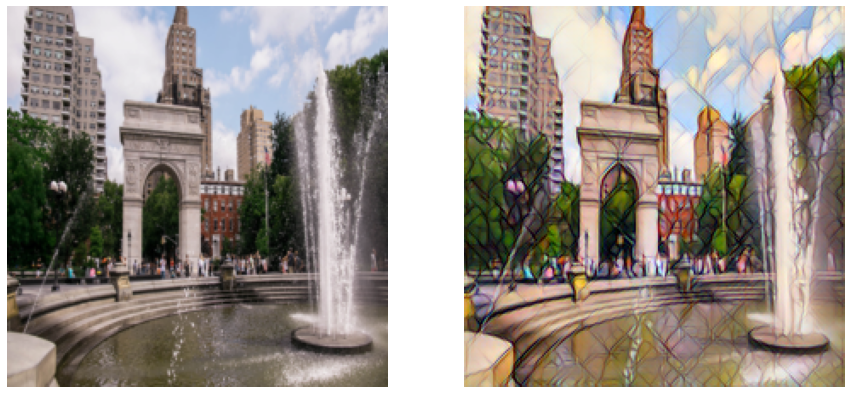

In [ ]:
# show image
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,15))
ax1.imshow(util.torchTensorToImage(content),label = "Content")
ax1.axis("off")
ax2.imshow(util.torchTensorToImage(stylized_img),label = "Stylized Content")
ax2.axis("off")
plt.show()